In [38]:
import numpy

import xarray

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap

import cmocean

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

import statsmodels.stats.multitest
import pyresample

In [35]:
data1 = xarray.open_dataset('data_atmos/data01.nc')

data_winter = xarray.open_dataset('data_atmos/data_winter3.nc')
data_spring = xarray.open_dataset('data_atmos/data_spring3.nc')
data_summer = xarray.open_dataset('data_atmos/data_summer3.nc')
data_fall = xarray.open_dataset('data_atmos/data_fall3.nc')

spectral = xarray.open_dataset('data_atmos/spectral.nc')

In [7]:
lon = numpy.load('data/lon.npy')
lat = numpy.load('data/lat.npy')

lat2 = numpy.arange(-90, -90 + 241*0.75, 0.75)
lon2 = numpy.arange(0, 360, 0.75)

# Resample from reduced Gaussian grid to regular grid for plotting
orig_def = pyresample.geometry.SwathDefinition(lons=lon - 180, lats=lat)
targ_def = pyresample.geometry.SwathDefinition(lons=numpy.meshgrid(lon2, lat2)[0].flatten() - 180,
                                               lats=numpy.meshgrid(lon2, lat2)[1].flatten())

In [24]:
data1['fdr_atmos_to_sst'] = (('cell', 'delay_sig'), numpy.full([88838, 25], numpy.NaN))
data1['fdr_sst_to_atmos'] = (('cell', 'delay_sig'), numpy.full([88838, 25], numpy.NaN))

for cell in range(1, 88839):
    data1['fdr_atmos_to_sst'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data1['sig_atmos_to_sst'][cell - 1, numpy.arange(0, 361, 15)],
                                                                                      alpha=0.1, method='fdr_bh')[0]
    data1['fdr_sst_to_atmos'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data1['sig_sst_to_atmos'][cell - 1, numpy.arange(0, 361, 15)],
                                                                                      alpha=0.1, method='fdr_bh')[0]

/homes/ebach/miniconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [25]:
persist_atmos_to_sst = numpy.full([88838], 0.0)
persist_sst_to_atmos = numpy.full([88838], 0.0)
for a in range(25):
    mask = (persist_atmos_to_sst >= 15*(a - 1)).astype(bool) & (data1['fdr_atmos_to_sst'][:, a].values != 0)
    persist_atmos_to_sst[mask] = (data1['fdr_atmos_to_sst'][:, a].values*15*a)[mask]
    
    mask = (persist_sst_to_atmos >= 15*(a - 1)).astype(bool) & (data1['fdr_sst_to_atmos'][:, a].values != 0)
    persist_sst_to_atmos[mask] = (data1['fdr_sst_to_atmos'][:, a].values*15*a)[mask]

persist_atmos_to_sst[(data1['fdr_atmos_to_sst'][:, 0] == 0) & (persist_atmos_to_sst == 0)] = numpy.NaN
persist_sst_to_atmos[(data1['fdr_sst_to_atmos'][:, 0] == 0) & (persist_sst_to_atmos == 0)] = numpy.NaN

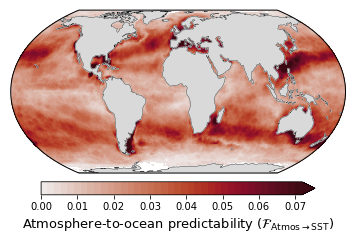

In [8]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data1['F_atmos_to_sst'][:, 0]
var[(data1['sig_atmos_to_sst'][:, 0] > 0.05)] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = 0, numpy.nanpercentile(var.data, 99)
levels = numpy.linspace(vmin, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Atmos}\rightarrow\mathrm{SST}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_atmos_to_sst.pdf')

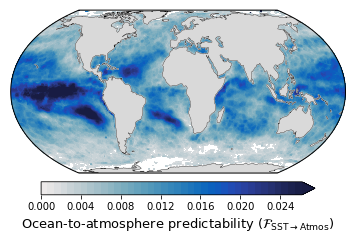

In [9]:
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data1['F_sst_to_atmos'][:, 0]
var[data1['sig_sst_to_atmos'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = 0, numpy.nanpercentile(var.data, 99)
levels = numpy.linspace(vmin, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Atmos}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_atmos.pdf')

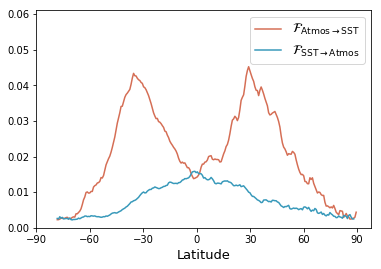

In [14]:
pts = []
pts2 = []
atmos_to_sst = data1['F_atmos_to_sst'][:, 0].load()
sst_to_atmos = data1['F_sst_to_atmos'][:, 0].load()

for l in numpy.unique(lat):
    pts.append((atmos_to_sst[(data1['sig_atmos_to_sst'][:, 0] < 0.05) & (lat == l)]).median().values)
    pts2.append((sst_to_atmos[(data1['sig_sst_to_atmos'][:, 0] < 0.05) & (lat == l)]).median().values)
plt.plot(numpy.unique(lat), pts, '#D56E55')
plt.plot(numpy.unique(lat), pts2, '#3899BA')
plt.xlabel('Latitude', size=13)
plt.xticks(numpy.linspace(-90, 90, 7))
plt.ylim([0, 0.061])
plt.legend([r'$\mathcal{F}_{\mathrm{Atmos}\rightarrow\mathrm{SST}}$', r'$\mathcal{F}_{\mathrm{SST}\rightarrow \mathrm{Atmos}}$'], fontsize=13)
plt.savefig('zonal_average_atmos.pdf')

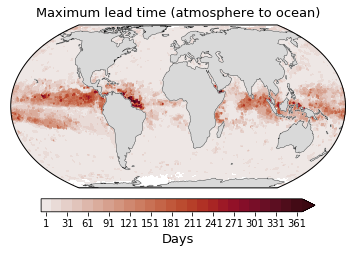

In [27]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth(central_longitude=0))
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist_atmos_to_sst.astype(float) + 1
var[data1['sig_atmos_to_sst'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-15/2, vmax + 15, 15) + 1

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.05, ticks=numpy.arange(0, vmax + 30, 30) + 1)
plt.title('Maximum lead time (atmosphere to ocean)', size=13, pad=8)
cb.set_label(r'Days', size=13)
plt.savefig('time_atmos_to_sst.pdf')

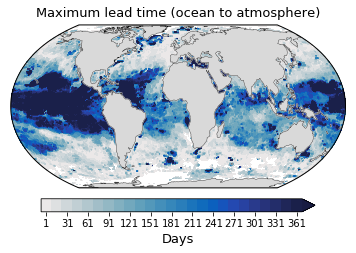

In [28]:
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)
levels = numpy.arange(-2.5, 35, 5)

plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist_sst_to_atmos.astype(float) + 1
var[data1['sig_sst_to_atmos'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 360#var.max()
levels = numpy.arange(-15/2, vmax + 15, 15) + 1

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.05, ticks=numpy.arange(0, vmax + 30, 30) + 1)
plt.title('Maximum lead time (ocean to atmosphere)', size=13, pad=8)
cb.set_label(r'Days', size=13)
plt.savefig('time_sst_to_atmos.pdf')

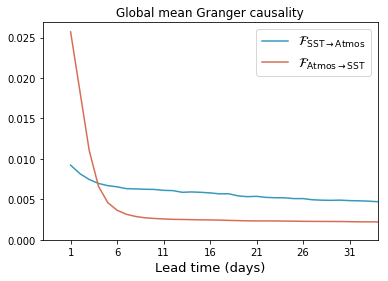

In [428]:
# Decay of predictability with time
plt.plot(range(1, 36), (data1['F_sst_to_atmos'].mean(axis=0)[:35]), '#3899BA')
plt.plot(range(1, 36), (data1['F_atmos_to_sst'].mean(axis=0)[:35]), '#D56E55')
plt.legend([r'$\mathcal{F}_{\mathrm{SST}\rightarrow \mathrm{Atmos}}$',
            r'$\mathcal{F}_{\mathrm{Atmos}\rightarrow \mathrm{SST}}$'], fontsize=13)
plt.title('Global mean Granger causality')
plt.xlabel('Lead time (days)', size=13)
plt.xlim([-2, 34])
plt.ylim([0, None])
plt.xticks(range(1, 36, 5))

plt.savefig('predictability_decay_atmos.pdf')

/homes/ebach/miniconda3/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


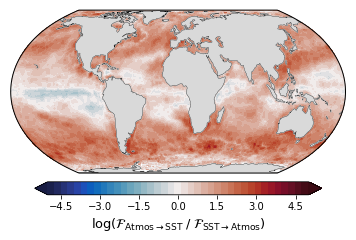

In [32]:
plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

ratio = numpy.log(data1['F_atmos_to_sst'][:, 0]/data1['F_sst_to_atmos'][:, 0])

var = numpy.ma.masked_invalid(ratio)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, levels=numpy.linspace(-5, 5, 40), cmap=cmocean.cm.balance,
             vmax=5, vmin=-5, extend='both', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\log\left(\mathcal{F}_{\mathrm{Atmos}\rightarrow \mathrm{SST}}\;/\;\mathcal{F}_{\mathrm{SST}\rightarrow \mathrm{Atmos}}\right)$', size=13)

plt.savefig('driver.pdf')

/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


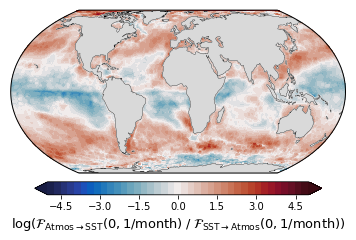

In [36]:
plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

ratio = numpy.log(numpy.trapz(spectral['f_atmos_to_sst'][:, :21], freqs[:21], axis=1)/numpy.trapz(spectral['f_sst_to_atmos'][:, :21], freqs[:21], axis=1))

var = numpy.ma.masked_invalid(ratio)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, levels=numpy.linspace(-5, 5, 40), cmap=cmocean.cm.balance,
             vmax=5, vmin=-5, extend='both', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\log\left(\mathcal{F}_{\mathrm{Atmos}\rightarrow \mathrm{SST}}(0, 1/\mathrm{month})\;/\;\mathcal{F}_{\mathrm{SST}\rightarrow \mathrm{Atmos}}(0, 1/\mathrm{month})\right)$', size=13)
plt.savefig('driver_lowfreq.pdf')

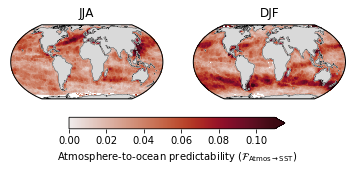

In [39]:
cmap = cmocean.cm.amp

ax = plt.subplot(1, 2, 1, projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_summer['F_atmos_to_sst'].copy()
var[data_summer['sig_atmos_to_sst'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.11
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

ax.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
            cmap=cmap, transform=ccrs.PlateCarree(),
            extend='max')
ax.set_title('JJA', pad=8)

ax = plt.subplot(1, 2, 2, projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_winter['F_atmos_to_sst'].copy()
var[data_winter['sig_atmos_to_sst'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.11
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

ax.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
            cmap=cmap, transform=ccrs.PlateCarree(),
            extend='max')
ax.set_title('DJF', pad=8)

fig = plt.gcf()
ax3 = fig.add_axes([0.26, 0.27, 0.5, 0.04])

cmap = cmocean.cm.amp
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.11)
cb1 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap, norm=norm,
                                       orientation='horizontal', extend='max')
cb1.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Atmos}\rightarrow\mathrm{SST}}$)')
tick_locator = ticker.MaxNLocator(nbins=7)
cb1.locator = tick_locator
cb1.update_ticks()

plt.savefig('seasonal_atmos_to_sst.pdf')

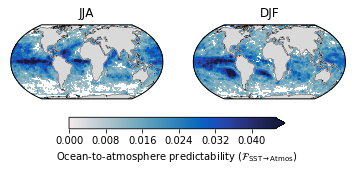

In [40]:
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

ax = plt.subplot(1, 2, 1, projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_summer['F_sst_to_atmos'].copy()
var[data_summer['sig_sst_to_atmos'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.045
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

ax.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
            cmap=cmap, transform=ccrs.PlateCarree(),
            extend='max')
ax.set_title('JJA', pad=8)

ax = plt.subplot(1, 2, 2, projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_winter['F_sst_to_atmos'].copy()
var[data_winter['sig_sst_to_atmos'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.045
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

ax.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
            cmap=cmap, transform=ccrs.PlateCarree(),
            extend='max')
ax.set_title('DJF', pad=8)

fig = plt.gcf()
ax3 = fig.add_axes([0.26, 0.27, 0.5, 0.04])

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.045)
cb1 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap, norm=norm,
                                       orientation='horizontal', extend='max')
cb1.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Atmos}}$)')
tick_locator = ticker.MaxNLocator(nbins=7)
cb1.locator = tick_locator
cb1.update_ticks()

plt.savefig('seasonal_sst_to_atmos.pdf')

/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


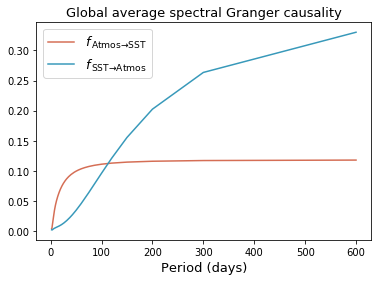

In [61]:
freqs = numpy.linspace(0, 0.5, 301)

plt.plot(1/freqs, numpy.nanmean(spectral['f_atmos_to_sst'], axis=0), '#D56E55')
plt.plot(1/freqs, numpy.nanmean(spectral['f_sst_to_atmos'], axis=0), '#3899BA')

plt.legend([r'$f_{\,\mathrm{Atmos}\to\mathrm{SST}}$', r'$f_{\,\mathrm{SST}\to\mathrm{Atmos}}$'], fontsize=13)
#plt.ylim(bottom=0)
plt.title(r'Global average spectral Granger causality', size=13)
plt.xlabel(r'Period (days)', size=13)
ax = plt.gca()
plt.savefig('spectral_atmos_period.pdf')

In [43]:
wmean_atmos_to_sst = (spectral['f_atmos_to_sst']*freqs).sum(axis=1)/numpy.sum(spectral['f_atmos_to_sst'], axis=1)
wmean_sst_to_atmos = (spectral['f_sst_to_atmos']*freqs).sum(axis=1)/numpy.sum(spectral['f_sst_to_atmos'], axis=1)

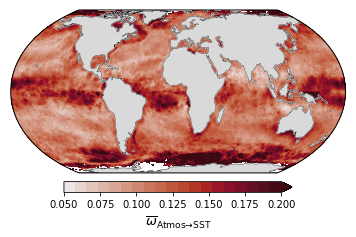

In [51]:
dat = wmean_atmos_to_sst.data

plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

dat[(data1['sig_atmos_to_sst'][:, 0] > 0.05)] = numpy.NaN
var = numpy.ma.masked_invalid(dat)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

vmin, vmax = 0.05, 0.2
levels = numpy.linspace(vmin, vmax, 20)

plt.contourf(lon_cyc, lat2, regridded, levels=levels, cmap=cmocean.cm.amp,
             extend='max', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\overline{\omega}_{\mathrm{Atmos}\to\mathrm{SST}}$', size=13)
plt.savefig('freq_atmos_to_sst.pdf')

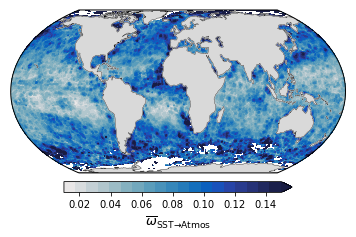

In [60]:
dat = wmean_sst_to_atmos.data

upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

dat[(data1['sig_sst_to_atmos'][:, 0] > 0.05)] = numpy.NaN
var = numpy.ma.masked_invalid(dat)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

vmin, vmax = 0.01, 0.15
levels = numpy.linspace(vmin, vmax, 20)

plt.contourf(lon_cyc, lat2, regridded, levels=levels, cmap=cmap,
             extend='max', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\overline{\omega}_{\mathrm{SST}\to\mathrm{Atmos}}$', size=13)
plt.savefig('freq_sst_to_atmos.pdf')

In [65]:
dat = wmean_atmos_to_sst.data
dat[(data1['sig_atmos_to_sst'][:, 0] > 0.05)] = numpy.NaN
print('Weighted-mean frequency of atmosphere-to-ocean predictability', numpy.nanmean(dat[dat > 0]))

dat = wmean_sst_to_atmos.data
dat[(data1['sig_sst_to_atmos'][:, 0] > 0.05)] = numpy.NaN
numpy.nanmean(dat[dat > 0])
print('Weighted-mean frequency of ocean-to-atmosphere predictability', numpy.nanmean(dat[dat > 0]))

Weighted-mean frequency of atmosphere-to-ocean predictability 0.11560783813881104
Weighted-mean frequency of ocean-to-atmosphere predictability 0.07337554360030445


/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [62]:
var_atmos = numpy.load('var_atmos.npy')
var_sst = numpy.load('var_sst.npy')

print('Fraction of generalized variance explained by atmos model', numpy.nanmean(1 - data1['mspe_full_sst_to_atmos'][:, 0]/var_atmos))
print('Fraction of variance explained by SST model', numpy.nanmean(1 - data1['mspe_full_atmos_to_sst'][:, 0]/var_sst))

Fraction of generalized variance explained by atmos model 0.9301906454916106
Fraction of variance explained by SST model 0.9381765656197508


In [105]:
reduced_winter = numpy.exp(data_winter['F_atmos_to_sst'])*data_winter['mspe_full_atmos_to_sst']
reduced_summer = numpy.exp(data_summer['F_atmos_to_sst'])*data_summer['mspe_full_atmos_to_sst']

In [108]:
# Summer hemisphere
mspe_sst = numpy.hstack([reduced_summer[lat > 0], reduced_winter[lat < 0]])
print('Root mean-square error for reduced SST model, NH summer', numpy.sqrt(numpy.nanmean(mspe_sst)))

Root mean-square error for reduced SST model, NH summer 0.17309000070552433


In [109]:
# Winter hemisphere
mspe_sst = numpy.hstack([reduced_winter[lat > 0], reduced_summer[lat < 0]])
print('Root mean-square error for reduced SST model, NH winter', numpy.sqrt(numpy.nanmean(mspe_sst)))

Root mean-square error for reduced SST model, NH winter 0.13219272645536187
